In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment140


target
0    800000
1    800000
Name: count, dtype: int64


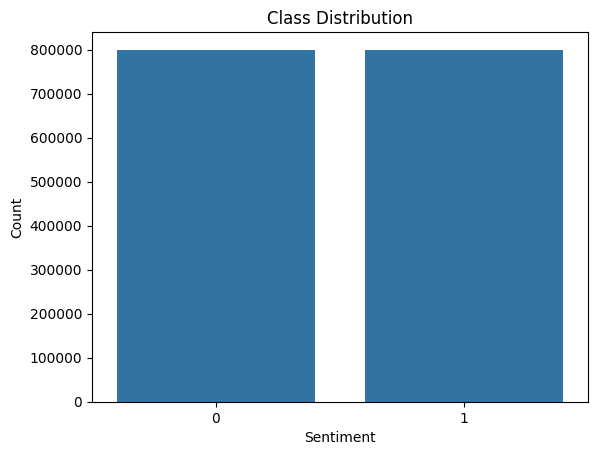

Train size: 800000, Test size: 800000


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv(f"{path}/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

print(df['target'].value_counts())

sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

train_df, test_df = train_test_split(
    df,
    test_size=0.5,
    stratify=df['target'],
    random_state=42
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


In [4]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()                             # lowercase
    text = re.sub(r"http\S+|www.\S+", "", text)     # remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)           # remove mentions/hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)         # remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['text'].apply(clean_text)
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


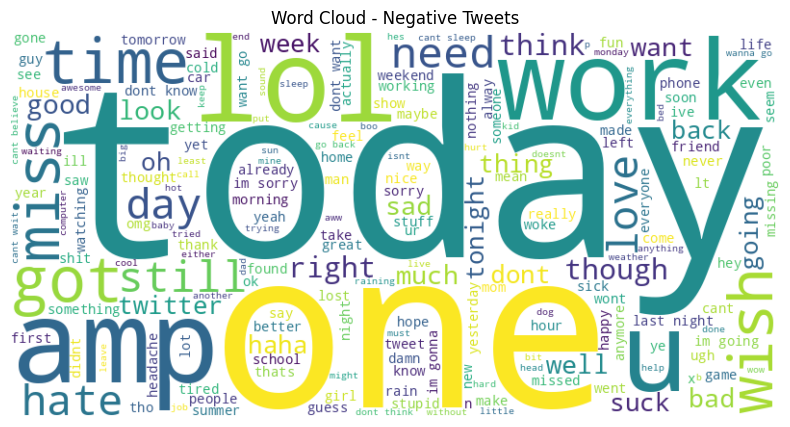

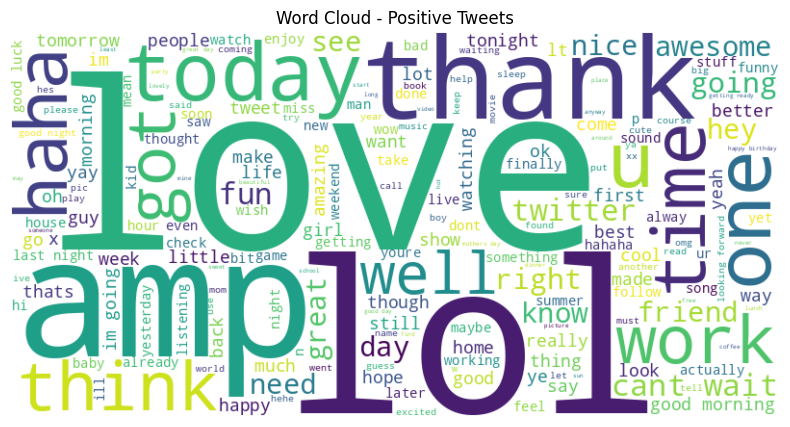

In [5]:
from wordcloud import WordCloud

# Word cloud for positive and negative tweets
for label in [0, 1]:
    text = " ".join(train_df[train_df["target"] == label]["clean_text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {'Negative' if label == 0 else 'Positive'} Tweets")
    plt.show()


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 30

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

X_train = tokenizer.texts_to_sequences(train_df['text'])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')

X_test = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

y_train = train_df['target'].values
y_test = test_df['target'].values

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(vocab_size, 100),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout,
                                     BatchNormalization, Bidirectional)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [9]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.12)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.003),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=8, batch_size=64,
                    validation_split=0.2)

Epoch 1/8
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 109s 10ms/step - accuracy: 0.7628 - loss: 0.6029 - val_accuracy: 0.8091 - val_loss: 0.4385
Epoch 2/8
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - accuracy: 0.8084 - loss: 0.4542 - val_accuracy: 0.8170 - val_loss: 0.4197
Epoch 3/8
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 141s 9ms/step - accuracy: 0.8144 - loss: 0.4418 - val_accuracy: 0.8162 - val_loss: 0.4270
Epoch 4/8
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 143s 10ms/step - accuracy: 0.8178 - loss: 0.4340 - val_accuracy: 0.8175 - val_loss: 0.4203
Epoch 5/8
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 142s 10ms/step - accuracy: 0.8217 - loss: 0.4281 - val_accuracy: 0.8172 - val_loss: 0.4237
Epoch 6/8
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step - accuracy: 0.8230 - loss: 0.4269 - val_accuracy: 0.8164 - val_loss: 0.4248
Epoch 7/8
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 142s 10ms/step - accuracy: 0.8247 - loss: 0.4250 - val_accuracy: 0.8139 - val_loss: 0.4291
Epoch 8/8
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 142s 10ms/step - accura

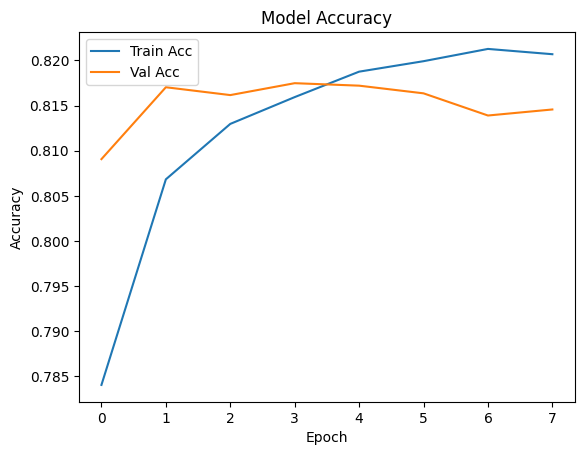

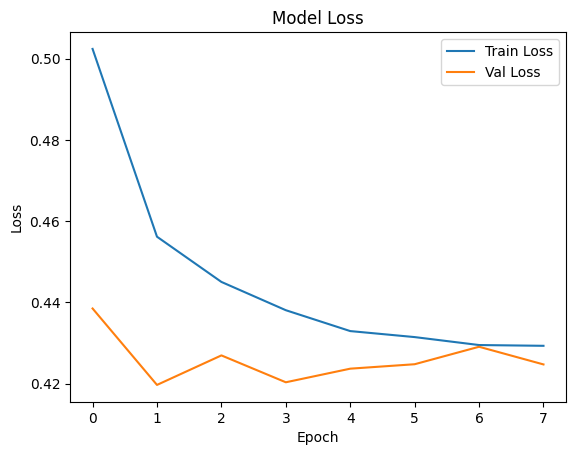

In [10]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Predict on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Accuracy score
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

10570/25000 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step

In [ ]:
def predict_sentiment(texts):
    # Tokenize and pad
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    # Predict
    preds = model.predict(padded)
    for i, text in enumerate(texts):
        sentiment = "Positive 😊" if preds[i] > 0.5 else "Negative 😠"
        print(f"\nInput: {text}\nPredicted Sentiment: {sentiment} (Confidence: {preds[i][0]:.2f})")

# 🔍 Example usage:
predict_sentiment([
    "I love the new features in the latest iPhone update! 📱🔥",
    "This is the worst customer service experience I've ever had. So disappointed.",
    "Just an average day, nothing too exciting or terrible.",
    "Totally amazed by the performance of the new Tesla model. Worth every penny!",
    "I can't believe how bad the weather is today... ruining my plans 😤",
    "Feeling grateful for all the support from my friends and followers 💖",
    "Why do these apps always crash when I need them the most? 😡",
])